In [ ]:
#!pip install pyquaternion
!pip install navpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from navpy import angle2quat
import matplotlib.pyplot as pyplot
import math
import random

deg2rad = np.pi/180
rad2deg = 1/deg2rad

g = 9.81 # m/s^2
U = 15*deg2rad/3600 # rad/sec
Re = 6371000 # Радиус на экваторе /m
b = 6356863 # m
a = 6378245 # m
e =np.sqrt(1-b**2/a**2) 

In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

In [ ]:
Tm = 15*4
Tv = 10

In [ ]:
mat = loadmat('/content/drive/MyDrive/Alg/nav.binB_03.mat')
data_df = pd.DataFrame(mat['UAV'])
data = data_df.to_numpy().T
data = np.delete(data, 0, 1)
data = data[405500:,:]
Sensors = np.zeros((6,2),dtype = np.float64)
n = data.shape[0]
acc = data[:,9:12]
gyro = data[:,12:15]

GPSQuality = data[:,23]
GPS = data[:,17:23]
GPS[:,0:2] = GPS[:,0:2] #* np.pi / 180

#StatusMS = data[:, 33]
#MagnSens = data[:, 30:33] * 10
#MagnSens[:,1:3] = -1 * MagnSens[:,1:3]

#dt = 1 / 100


In [ ]:
# Чтение файла
def find_znach(buf_str, flag): 
    if buf_str!='':
        #разбиваем строку
        split_str = buf_str.split('  ')

        time = split_str[0]

        #три акселерометра
        accel_1= split_str[9]
        accel_2= split_str[10]
        accel_3= split_str[11]

        #гироскопы
        sav_1 = split_str[12]
        sav_2 = split_str[13]
        sav_3 = split_str[14]
        
        GPS_lat = split_str[20]
        GPS_lon =split_str[21]
        p_fromFile = split_str[1]  #Тангаж
        r_fromFile = split_str[2]  #Крен
        h_fromFile = split_str[3] #Курс
        Ve = split_str[15]
        Vn = split_str[16]

        GPS_Speed = split_str[23]
        GPS_Heading = split_str[24]


        flag=True
        return [time, accel_1, accel_2, accel_3, sav_1, sav_2, sav_3, GPS_lat, GPS_lon, p_fromFile, r_fromFile, h_fromFile, Ve, Vn, GPS_Speed, GPS_Heading, flag]

    else:
        flag=False
        return ['' for i in range(9)]+[flag]

#f=open('/content/drive/MyDrive/Alg/101003-0757Saratov.txt', 'r') 

phi = []
lmbda=[]

phi_GPS = []
lmbda_GPS=[]

gamm=[]
thett=[]
kurs_ist=[]

a_1 = []
a_2 = []
a_3 = []

dus_1 = []
dus_2 = []
dus_3 = []

time_ar = []
p_fromFile = []
r_fromFile = []
h_fromFile = []

Ve_GPS = []
Vn_GPS = []

ft = 0.01
flag_EOF = True #устанавливаем флаг в истину, т.к. мы только что открыли файл и находимся в его начале
x = 0
it = 0
tbuf = 0
cl = 0
j = 0
time_GPS = []

#flag_EOF = False
#for i in range(8): #36 сек
  #buf_str = f.readline()

#j = 0
#(flag_EOF) and 
while (cl != Tm*60/0.01):
    #buf_str=f.readline() #читаем строку из файла, чтобы потом определить значения градуса, минут и секунд
    #print(buf_str)
    #t, accel_1, accel_2, accel_3, sav_1, sav_2, sav_3, GPS_lat, GPS_lon, p_fromFile_str, r_fromFile_str, h_fromFile_str, Ve, Vn, GPS_Speed, GPS_Heading, flag_EOF = find_znach(buf_str,flag_EOF)

    a_1.append(acc[cl, 2]/ft)
    a_2.append(acc[cl, 0]/ft)
    a_3.append(acc[cl, 1]/ft)
    dus_1.append(gyro[cl, 2]/ft)#*deg2rad)
    dus_2.append(gyro[cl, 0]/ft)#*deg2rad)
    dus_3.append(-gyro[cl, 1]/ft)#*deg2rad)

    #if flag_EOF:
    phi_GPS.append(GPS[cl, 0])
    lmbda_GPS.append(GPS[cl, 1])

 #   p_fromFile.append(float(p_fromFile_str))  #Тангаж
 #   r_fromFile.append(float(r_fromFile_str))  #Крен
 #   h_fromFile.append(float(h_fromFile_str)) #Курс
    time_GPS.append(ft*j/60)
      
 #   Ve_GPS.append(float(Ve))
 ##   Vn_GPS.append(float(Vn))
      #Ve_GPS.append(float(GPS_Speed)*np.cos(float(GPS_Heading)*deg2rad))
      #Vn_GPS.append(float(GPS_Speed)*np.sin(float(GPS_Heading)*deg2rad))

      #j = j + 1
    cl = cl + 1
#f.close() 
print(cl)

360000


In [ ]:
def quat2(H, gamma, theta):
  q0 = np.cos(H/2)*np.cos(theta/2)*np.cos(gamma/2)-np.sin(H/2)*np.sin(theta/2)*np.sin(gamma/2) 
  q1 = np.cos(H/2)*np.cos(theta/2)*np.sin(gamma/2)+np.sin(H/2)*np.sin(theta/2)*np.cos(gamma/2) #+
  q2 = np.sin(H/2)*np.cos(theta/2)*np.cos(gamma/2)+np.cos(H/2)*np.sin(theta/2)*np.sin(gamma/2) #-
  q3 = np.cos(H/2)*np.sin(theta/2)*np.cos(gamma/2)-np.sin(H/2)*np.cos(theta/2)*np.sin(gamma/2) #-
  Q = np.array([q0, q1, q2, q3])
  return Q

In [ ]:
def qProd(a:np.array, b:np.array):   # Произведение кватернионов
  ab = np.array([0.0, 0.0, 0.0, 0.0])
  ab[0] = a[0]*b[0]-a[1]*b[1]-a[2]*b[2]-a[3]*b[3]
  ab[1] = a[0]*b[1]+a[1]*b[0]+a[2]*b[3]-a[3]*b[2]
  ab[2] = a[0]*b[2]-a[1]*b[3]+a[2]*b[0]+a[3]*b[1]
  ab[3] = a[0]*b[3]+a[1]*b[2]-a[2]*b[1]+a[3]*b[0]                     
  return ab

In [ ]:
def normalization(a:np.array):  # Нормализация кватерниона
  ab = np.array([0.0, 0.0, 0.0, 0.0])
  norm = np.sqrt(a[0]**2+a[1]**2+a[2]**2+a[3]**2)
  ab[0] = a[0]/norm
  ab[1] = a[1]/norm
  ab[2] = a[2]/norm
  ab[3] = a[3]/norm
  return ab

In [ ]:
def conjQuat(a:np.array):
  a[0] = a[0]
  a[1] = -a[1]
  a[2] = -a[2]
  a[3] = -a[3]
  return a

In [ ]:
def quat(H, gamma, theta):
  q0 = np.cos(H/2)*np.cos(theta/2)*np.cos(gamma/2)+np.sin(H/2)*np.sin(theta/2)*np.sin(gamma/2) 
  q1 = np.cos(H/2)*np.sin(theta/2)*np.cos(gamma/2)+np.sin(H/2)*np.cos(theta/2)*np.sin(gamma/2) #+
  q2 = np.cos(H/2)*np.cos(theta/2)*np.sin(gamma/2)-np.sin(H/2)*np.sin(theta/2)*np.cos(gamma/2) #-
  q3 = np.cos(H/2)*np.sin(theta/2)*np.sin(gamma/2)-np.sin(H/2)*np.cos(theta/2)*np.cos(gamma/2) #-
  Q = np.array([q0, q1, q2, q3])
  return Q

In [ ]:
def CBLL2(H, gamma, theta):
  C_bLL = np.array([[np.cos(gamma)*np.cos(H)+np.sin(gamma)*np.sin(theta)*np.sin(H), np.cos(theta)*np.sin(H), np.sin(gamma)*np.cos(H)-np.cos(gamma)*np.sin(H)*np.sin(theta)],
  [-np.cos(gamma)*np.sin(H)+np.sin(gamma)*np.sin(theta)*np.cos(H), np.cos(theta)*np.cos(H), -(np.sin(gamma)*np.sin(H)+np.cos(gamma)*np.sin(theta)*np.cos(H))],
  [-np.sin(gamma)*np.cos(theta), np.sin(theta), np.cos(gamma)*np.cos(theta)]])
  return C_bLL

In [ ]:
def CBLL(H, gamma, theta):
    C_bLL = np.array([[np.cos(gamma)*np.cos(H)+np.sin(gamma)*np.sin(theta)*np.sin(H), np.sin(theta)*np.sin(H), np.sin(gamma)*np.cos(H)-np.cos(gamma)*np.sin(H)*np.sin(theta)],
    [-np.cos(gamma)*np.sin(H)+np.sin(gamma)*np.sin(theta)*np.cos(H), np.cos(theta)*np.cos(H), -(np.sin(gamma)*np.sin(H)+np.cos(gamma)*np.sin(theta)*np.cos(H))],
    [-np.sin(gamma)*np.cos(theta), np.sin(theta), np.cos(gamma)*np.cos(theta)]])
    return C_bLL

In [ ]:
def quat2DCM(Q2:np.array):
  c11 = Q2[0]**2 + Q2[1]**2 - Q2[2]**2 - Q2[3]**2
  c12 = 2*(Q2[1]*Q2[2] - Q2[0]*Q2[3])
  c13 = 2*(Q2[1]*Q2[3] + Q2[0]*Q2[2])
  c21 = 2*(Q2[1]*Q2[2] + Q2[0]*Q2[3])
  c22 = Q2[0]**2 - Q2[1]**2 + Q2[2]**2 - Q2[3]**2
  c23 = 2*(Q2[2]*Q2[3] - Q2[0]*Q2[1])
  c31 = 2*(Q2[1]*Q2[3] - Q2[0]*Q2[2])
  c32 = 2*(Q2[2]*Q2[3] + Q2[0]*Q2[1])
  c33 = Q2[0]**2 - Q2[1]**2 - Q2[2]**2 + Q2[3]**2
  C_bLL = np.array([[c11, c12, c13], [c21, c22, c23], [c31, c32, c33]])
  return C_bLL

In [ ]:
def quat2DCM2(Q2:np.array):
  c11 = 2*(Q2[0]*Q2[0]+Q2[1]*Q2[1])-1
  c12 = 2*(Q2[1]*Q2[2]-Q2[0]*Q2[3])
  c13 = 2*(Q2[1]*Q2[3]+Q2[0]*Q2[2])
  c21 = 2*(Q2[1]*Q2[2]+Q2[0]*Q2[3]) # Без -
  c22 = 2*(Q2[0]*Q2[0]+Q2[2]*Q2[2])-1
  c23 = 2*(Q2[2]*Q2[3]-Q2[0]*Q2[1]) # Без -
  c31 = 2*(Q2[1]*Q2[3]-Q2[0]*Q2[2])
  c32 = 2*(Q2[2]*Q2[3]+Q2[0]*Q2[1])
  c33 = 2*(Q2[0]*Q2[0]+Q2[3]*Q2[3])-1
  C_bLL = np.array([[c11, c12, c13], [c21, c22, c23], [c31, c32, c33]])
  return C_bLL

In [ ]:
def EulerFromDCM(C_bLL:np.array):

  H_d = np.arctan(C_bLL[0, 1]/C_bLL[1, 1])
  if H_d < 0:
    H_d = H_d + 2*np.pi

  g_d = -np.arctan(C_bLL[2, 0]/C_bLL[2, 2])
  c0 = np.sqrt(C_bLL[2, 0]**2 + C_bLL[2, 2]**2)
  c0 = np.sqrt(C_bLL[0, 1]**2 + C_bLL[1, 1]**2)
  t_d = np.arctan(C_bLL[2, 1]/c0)

  return [H_d, g_d, t_d]

In [ ]:
def align3(time, a_b:np.array, omb:np.array, a_bx, a_by, a_bz, om_bx, om_by, om_bz):

  om_bx_s = 1
  om_by_s = 1
  om_bz_s = 1
  a_bx_s =  1
  a_by_s =  1
  a_bz_s =  1

  if time == 0:
    time = 1
  a_bx = a_b[0] + a_bx
  a_by = a_b[1] + a_by
  a_bz = a_b[2] + a_bz
  
  om_bx = omb[0] + om_bx
  om_by = omb[1] + om_by
  om_bz = omb[2] + om_bz
  #time = time + 1
  #if time >= 1:
#  a_bx_s =  a_bx/time
#  a_by_s =  a_by/time
#  a_bz_s =  a_bz/time
  
#  om_bx_s = om_bx/time
#  om_by_s = om_by/time
#  om_bz_s = om_bz/time


#  H = np.arctan((a_bx_s*om_bz_s - a_bz_s*om_bx_s)/(g*om_by_s - a_by_s*U*np.sin(fi)))
#  gamma = -np.arctan((a_bx_s/a_bz_s))
#  theta = np.arctan((a_by_s/np.sqrt(a_bx_s**2+a_bz_s**2)))

  return [H, gamma, theta, a_bx, a_by, a_bz, om_bx, om_by, om_bz]

In [ ]:
def DCMprod(C_bLL:np.array, acs_b:np.array):
  acs_LL = [0, 0, 0]
  acs_LL[0] = C_bLL[0, 0]*acs_b[0] + C_bLL[0, 1]*acs_b[1] + C_bLL[0, 2]*acs_b[2]
  acs_LL[1] = C_bLL[1, 0]*acs_b[0] + C_bLL[1, 1]*acs_b[1] + C_bLL[1, 2]*acs_b[2]
  acs_LL[2] = C_bLL[2, 0]*acs_b[0] + C_bLL[2, 1]*acs_b[1] + C_bLL[2, 2]*acs_b[2]
  return acs_LL

In [ ]:
def sculling(om_b:np.array, acs_b:np.array, W_sc_old:np.array, count):
  W_sc = np.zeros(3) 
  W_sc[0] = W_sc_old[0] + W_sc_old[1]*om_b[2]-W_sc_old[2]*om_b[1] + acs_b[0] 
  W_sc[1] = W_sc_old[1] + W_sc_old[2]*om_b[0]-W_sc_old[0]*om_b[2] + acs_b[1]
  W_sc[2] = W_sc_old[2] + W_sc_old[0]*om_b[1]-W_sc_old[1]*om_b[0] + acs_b[2]
  count = count + 1
  if count == 8:
    W_sc_old = np.zeros(3)
    count = 0
  return W_sc   

In [ ]:
def coning(om_b:np.array, om_b_old:np.array, f):
  Sk = [0, 0, 0]
  Sk[0] = om_b[0]*f + 1/12*(om_b_old[1]*om_b[2]-om_b_old[2]*om_b_old[1])
  Sk[1] = om_b[1]*f + 1/12*(om_b_old[2]*om_b[0]-om_b_old[0]*om_b_old[2])
  Sk[2] = om_b[2]*f + 1/12*(om_b_old[0]*om_b[1]-om_b_old[1]*om_b_old[0])
  return Sk

In [ ]:
# ENUp
H = 0 # 30*deg2rad # курс
gamma = 0 # 10*deg2rad # крен
theta = 0 # 20*deg2rad # тангаж

# Начальная матрица ориентации
C_bLL = CBLL(H, gamma, theta)
# Начальный кватернион ориентации
#Q = quat(H, gamma, theta)

In [ ]:
# Перепроектирование векторов в связанной СК
g_Nav = np.array([0, 0, g])
C_LLb = C_bLL.T
#C_llb = C_LLb
C_LLb_Mod = C_LLb
gb = np.dot(C_LLb_Mod,g_Nav)
#print(gb)

In [ ]:
# Инициализация массивов и н.у.
Ve = 0
Vn=0
Vup = 0
phi.append(0)
lmbda.append(0)

phi[0] = phi_GPS[0]*deg2rad
lmbda[0] = lmbda_GPS[0]*deg2rad

fi = phi[0]#*deg2rad
lm = lmbda[0]#*deg2rad
fi0 = fi
lm0 = lm
Upr = np.array([0,U*np.cos(fi),U*np.sin(fi)]) # E - N - Up

Ve_arr = []
Ve_arr.append(0)
Vn_arr = []
Vn_arr.append(0)
H_arr = []
H_arr.append(0) #h_fromFile[0])
gamma_arr=[]
gamma_arr.append(0) #r_fromFile[0])
theta_arr=[]
theta_arr.append(0) #p_fromFile[0])
phi_arr = []
lmd_arr = []
om_LL = Upr 

g_Nav = np.array([0, 0, g]).reshape(3, 1)
#g_Nav[0] = 0.00001
g_Nav[1] = g_Nav[0]

acs_LL = []
time = []
time.append(0)

#print(h_fromFile[0], r_fromFile[0], p_fromFile[0])


Tsh=84.4*60
#Период собственных колебаний ошибок БИНС
 
Ts=400
omegas=2*np.pi/Ts
omegash=2*np.pi/Tsh
#коррекция позиционная
hi=Tsh/Ts
k1=1.75*omegash*hi
k2=2.15*hi**2-1
k3=hi**3*omegash-1.75*hi*omegash

In [ ]:
ombx_arr = []
omby_arr = []
ombz_arr = []

acsbx_arr = []
acsby_arr = []

acsLx_arr = []
acsLy_arr = []

acsLke_arr = []
acsLkn_arr = []

In [ ]:
Upr = np.array([0,U*np.cos(fi),U*np.sin(fi)]).reshape(3, 1)
a_b = np.dot(C_LLb_Mod,g_Nav)
omb = np.dot(C_LLb_Mod,Upr)
omb = []
a_b = []
a_bx = 0
a_by = 0
a_bz = 0
om_bx = 0
om_by = 0
om_bz = 0

T = Tm * 60
f = 0.01 # 100 Гц частота
delta = 10**(-6)
p = 0
H_check = []
t_check = []
Q2 = np.array([1, 0, 0, 0])
C_bLL_v = C_bLL

# Initial conditions for sculling
W_sc_old = np.zeros(3)
count = 0

### Выставка

In [ ]:
for i in range(int(Tv*60/f)): 
  t = i

  # Выставка
  #if i <= 11*60/f:  

  time.append(f*i/60)
    
  # Считивание элементов из массива файла
  omb = [dus_1[i], dus_2[i], dus_3[i]]
  a_b = [a_1[i], a_2[i], a_3[i]]

  H_d, g_d, t_d, a_bx, a_by, a_bz, om_bx, om_by, om_bz = align3(i, a_b, omb, a_bx, a_by, a_bz, om_bx, om_by, om_bz)
  #H_d = 90*deg2rad
  #t_d = -1.2*deg2rad
  #g_d = 1.2*deg2rad
    #print(Q2v)
    #print(q0, qvec)
  #Q2v = [q0, -qvec[0], -qvec[1], -qvec[2]]
    #Q2v = quat(h_fromFile[i], r_fromFile[i], p_fromFile[i])
    #Q2v = normalization(Q2)
  
    #print(C_bLL)
  H_d, g_d, t_d = EulerFromDCM(C_bLL_v)
    #print(H_d*rad2deg, g_d*rad2deg, t_d*rad2deg)
  if time[i] == 0:
    time[i] = time[i] + f
    i = 1
  a_bx_s =  a_bx/i
  a_by_s =  a_by/i
  a_bz_s =  a_bz/i
  
  om_bx_s = om_bx/i
  om_by_s = om_by/i
  om_bz_s = om_bz/i

  H_d = np.arctan((a_bx_s*om_bz_s - a_bz_s*om_bx_s)/(g*om_by_s - a_by_s*U*np.sin(fi)))
  g_d = -np.arctan((a_bx_s/a_bz_s))
  t_d = np.arctan((a_by_s/np.sqrt(a_bx_s**2+a_bz_s**2)))
  if H_d*rad2deg < 0:
    H_d = H_d + 2*np.pi
  H_arr.append((H_d)*rad2deg)
  gamma_arr.append(g_d*rad2deg)
  theta_arr.append(t_d*rad2deg)
  #if i > 0:
  #H_d = 333.26*deg2rad
  #g_d = -0.87*deg2rad
  #t_d = 6.02*deg2rad
  Q2v = quat(H_d, g_d, t_d)
  q0, qvec = angle2quat(H_d,g_d,t_d)
  C_bLL_v = quat2DCM(Q2v)

  phi_arr.append(fi*rad2deg)
  lmd_arr.append(lm*rad2deg)
  Ve_arr.append(0) #Ve_GPS[i])
  Vn_arr.append(0) #Vn_GPS[i])

  ombx_arr.append(dus_1[i])#*rad2deg)
  omby_arr.append(dus_2[i])#*rad2deg)
  ombz_arr.append(dus_3[i])#*rad2deg)
  acsbx_arr.append(a_1[i])
  acsby_arr.append(a_2[i])
  acsLx_arr.append(0)
  acsLy_arr.append(0)

  acsLkn_arr.append(0)
  acsLke_arr.append(0)

  
Q2 = Q2v
C_bLL = C_bLL_v
print(H_d*rad2deg, g_d*rad2deg, t_d*rad2deg)

331.27064821853907 -0.8738572193326769 6.0212573016307385


## Навигационный алгоритм

In [ ]:
for i in range(int(Tv*60/f), int(T/f)): 
  #elif i > 11*60/f:

  time.append(f*i/60)
  # Параметры земли в текущей координате
  Rl = Re/((1-e**2*np.sin(fi)*np.sin(fi))**(1/2)) #*4
  Rphi = Re*(1-e**2)/((1-e**2*np.sin(fi)*np.sin(fi))**(3/2)) #*2

  # Навигационный алгoритм
  ombx_arr.append(dus_1[i])#*rad2deg)
  omby_arr.append(dus_2[i])#*rad2deg)
  ombz_arr.append(dus_3[i])#*rad2deg)
  acsbx_arr.append(a_1[i])
  acsby_arr.append(a_2[i])

  # Измерения с ДУС ---------------------
  om_b = np.array([dus_1[i], dus_2[i], dus_3[i]])
  om_b_old = [dus_1[i-1], dus_2[i-1], dus_3[i-1]]
  Sk = coning(om_b, om_b_old, f)
  # Расчет ориентации
#-----------------
  #dF = np.sqrt(dus_1[i]*dus_1[i]*f*f+dus_2[i]*dus_2[i]*f*f+dus_3[i]*dus_3[i]*f*f)
  #r = 1/2-dF**2/42+dF**4/3840
  #l0 = 1 - dF**2/8 + dF**4/384
  #l1 = r * dus_1[i]*f
  #l2 = r * dus_2[i]*f
  #l3 = r * dus_3[i]*f
  #dQ1 = [[l0, -l1, -l2, -l3], [l1, l0, l3, -l2], [l2, -l3, l0, l1], [l3, l2, -l1, l0]]
  #Q1 = np.dot(dQ1, Q2)
  #dQ1 = np.array([np.cos(dF/2), dus_1[i]*f/dF*np.sin(dF/2), dus_2[i]*f/dF*np.sin(dF/2), dus_3[i]*f/dF*np.sin(dF/2)])

  dQ1 = np.array([1, 0.5*0.1*Sk[0], -0.5*0.1*Sk[1], 0.5*Sk[2]], dtype=object) 
  Q1 = qProd(Q2, dQ1)


  #dF2 = np.sqrt(om_LL[0]*om_LL[0]+om_LL[1]*om_LL[1]+om_LL[2]*om_LL[2])
  #m0 = np.cos(dF2*f/2)
  #m1 = -om_LL[0]*f/dF2*np.sin(dF2*f/2)
  #m2 = -om_LL[1]*f/dF2*np.sin(dF2*f/2)
  #m3 = -om_LL[2]*f/dF2*np.sin(dF2*f/2)
  #dQ2 = [m0, m1, m2, m3]
  #Q1f = [[Q1[0], -Q1[1], -Q1[2], -Q1[3]], [Q1[1], Q1[0], Q1[3], -Q1[2]], [Q1[2], -Q1[3], Q1[0], Q1[1]], [Q1[3], Q1[2], -Q1[1], Q1[0]]]
  #Q2 = np.dot(Q1f, dQ2)
  #dQ2 = np.array([np.cos(dF2/2), -om_LL[0]/dF2*np.sin(dF2*f/2), -om_LL[1]/dF2*np.sin(dF2*f/2), -om_LL[2]/dF2*np.sin(dF2*f/2)])

  dQ2 = np.array([1, -0.5*om_LL[0]*f,  -0.5*om_LL[1]*f,  -0.5*om_LL[2]*f], dtype=object)  
  Q2 = qProd(dQ2, Q1)

  #Q2 = Q1
#-----------------  
  if np.abs(1 - np.sqrt(Q2[0]**2 + Q2[1]**2 + Q2[2]**2 + Q2[3]**2)) > delta:
    Q2 = normalization(Q2)

  C_bLL = quat2DCM(Q2)

  H_d, g_d, t_d = EulerFromDCM(C_bLL) #_S
    
  if p == 0:
    print("2   C_bLL ", C_bLL) #_S

  H_arr.append(H_d*rad2deg)
  gamma_arr.append(g_d*rad2deg)
  theta_arr.append(t_d*rad2deg)
    #Q2 = Q21
    #-----------
    # Измерения с акселерометров ----------------
  acs_b = [a_1[i], a_2[i], a_3[i]]#)#.reshape(3,1) np.array(
  W_sc_old = [a_1[i-1], a_2[i-1], a_3[i-1]]
  W_b = sculling(om_b, acs_b, W_sc_old, count)
  # Rotation of the acceleration vector
  #acs_LL = np.dot(C_bLL, acs_b) # Without sculling
  acs_LL = np.dot(C_bLL, W_b) # With sculling
  #acs_LL = acs_b

    #acs_LL = DCMprod(C_bLL, acs_b)
  #if i % 10000 == 0:
   # print("3  body",acs_b)
   # print("4  LL", acs_LL)
      
  acsLx_arr.append(acs_LL[0])
  acsLy_arr.append(acs_LL[1])

    # Кориолисовы добавки
  ae_k = acs_LL[0] - Vup*(Upr[1]+om_LL[1]) + Vn*(Upr[2]+om_LL[2]) # East channel
  an_k = acs_LL[1] - Ve*(Upr[2]+om_LL[2]) + om_LL[0]*Vup # North channel
     
  acsLkn_arr.append(an_k)
  acsLke_arr.append(ae_k)

  if p == 50000:
    print(ae_k)

    # Интегрирование ускорений
  Vn = Vn + an_k*f# * 0.1 
  Ve = Ve + ae_k*f# * 0.1

    # Массив линейных скоростей
  Vn_arr.append(Vn)
  Ve_arr.append(Ve)
        
    # Расчет относительных угловых скоростей
  om_LL[0] = -Vn/Rphi # omega E
  om_LL[1] = Ve/Rl + Upr[1] # omega N  
  om_LL[2] = Ve/Rl*np.tan(fi) + Upr[2] # omega Up
  if p == 0:
    print("om_LL ", om_LL)
    # Интегрирование скоростей
  fi = fi + Vn/Rphi*f#*0.1
  lm = lm + Ve/(Rl*np.cos(fi))*f#*0.1

    # Массив координат
  phi_arr.append(fi*rad2deg)
  lmd_arr.append(lm*rad2deg)  

  Upr = np.array([0, U*np.cos(fi), U*np.sin(fi)], dtype=object)
  p = p + 1

2   C_bLL  [[ 0.87756707 -0.47802089  0.03704135]
 [ 0.47921392  0.87206226 -0.09930472]
 [ 0.01516737  0.10489728  0.99436739]]
om_LL  [-3.79425857e-12  4.17326758e-05  5.95556877e-05]
[-0.13689599]


## Построение графиков

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


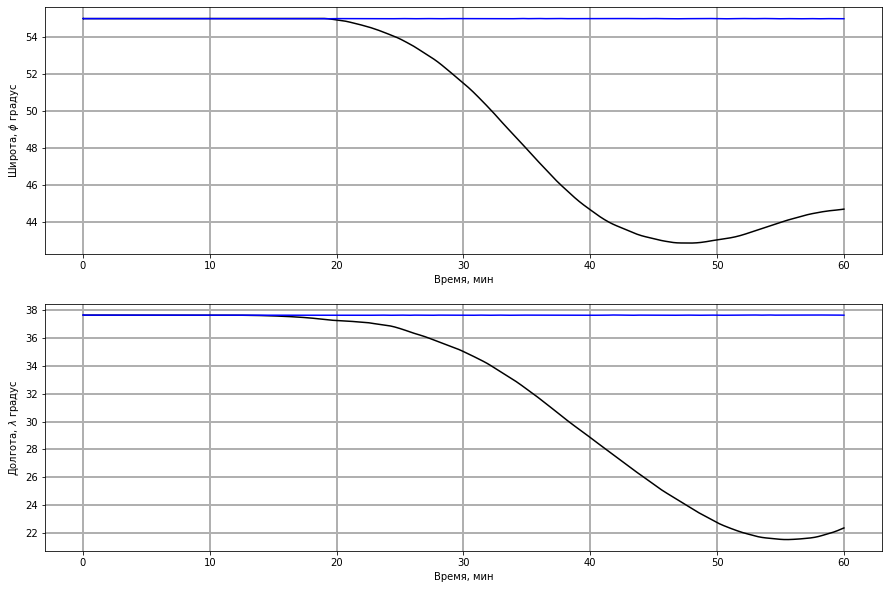

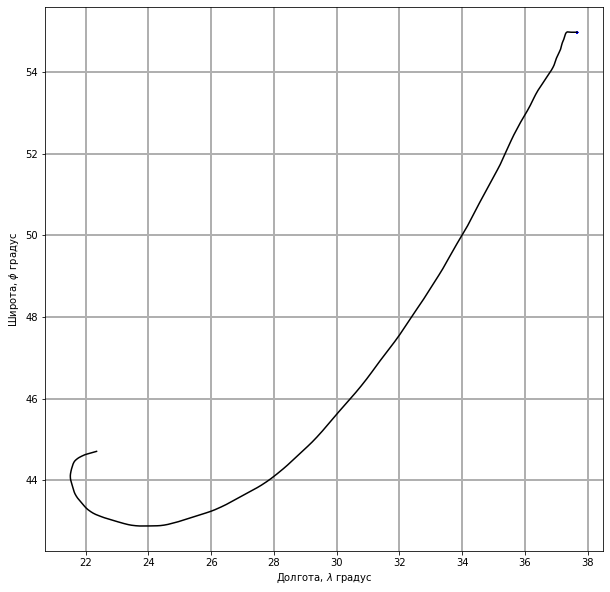

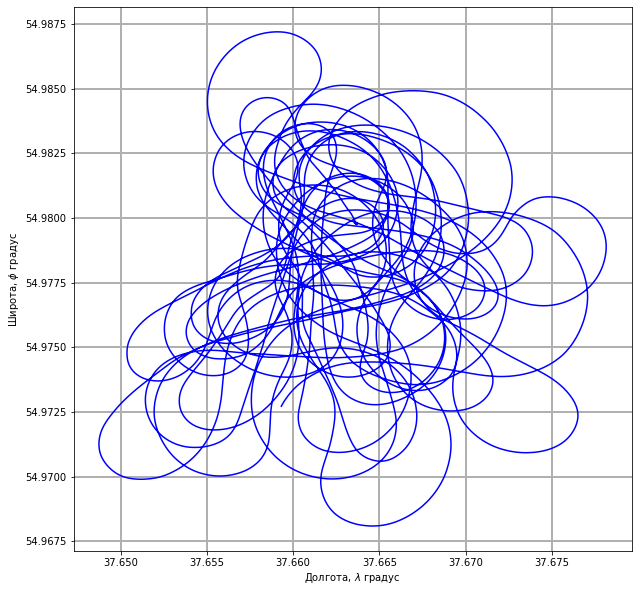

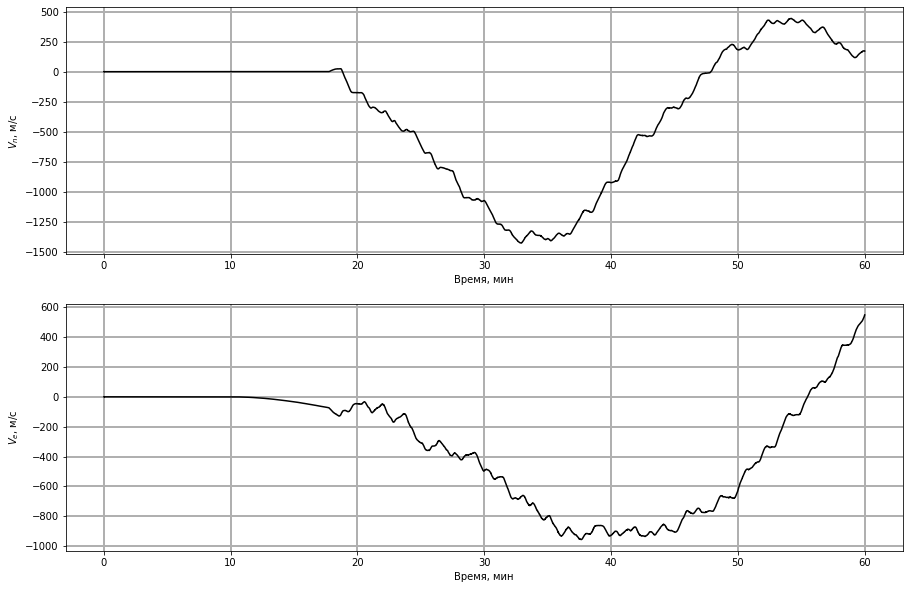

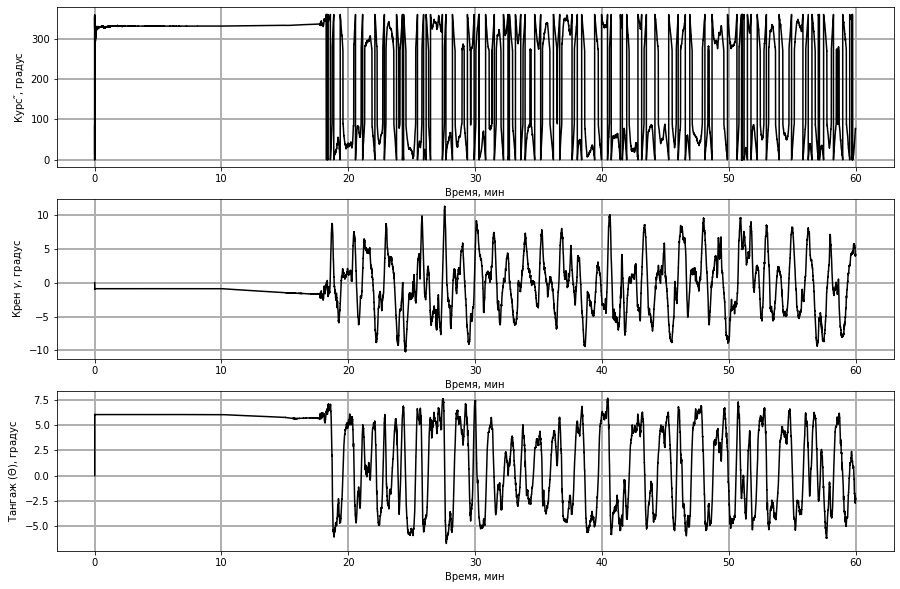

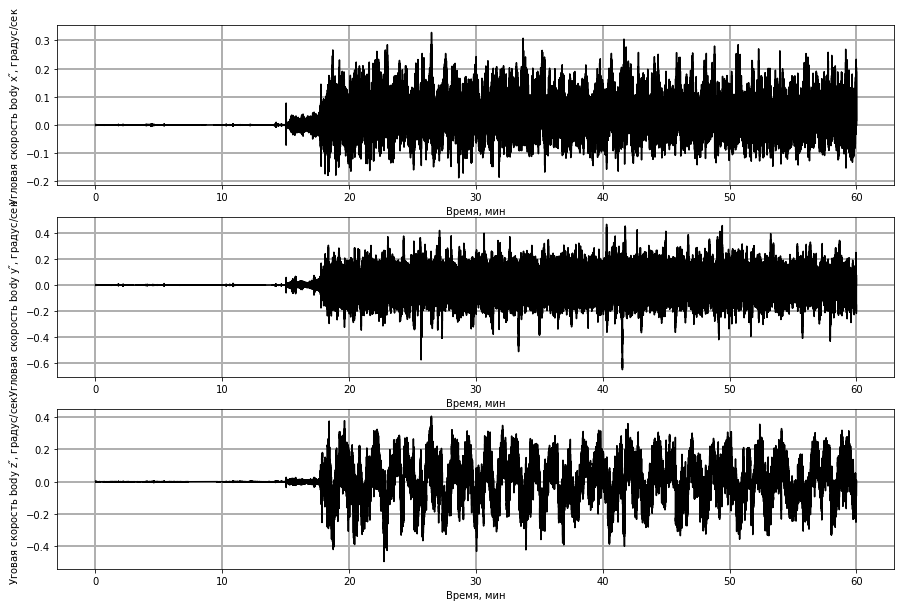

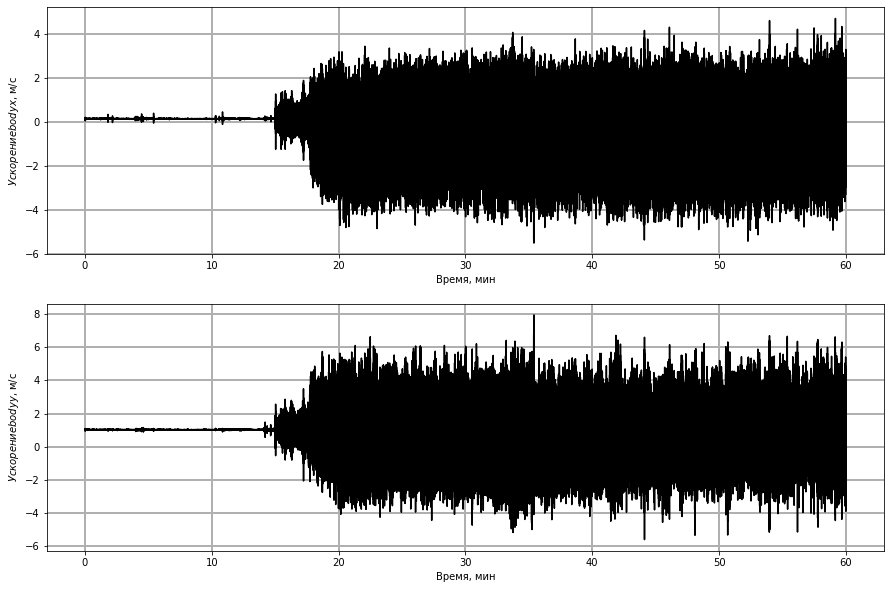

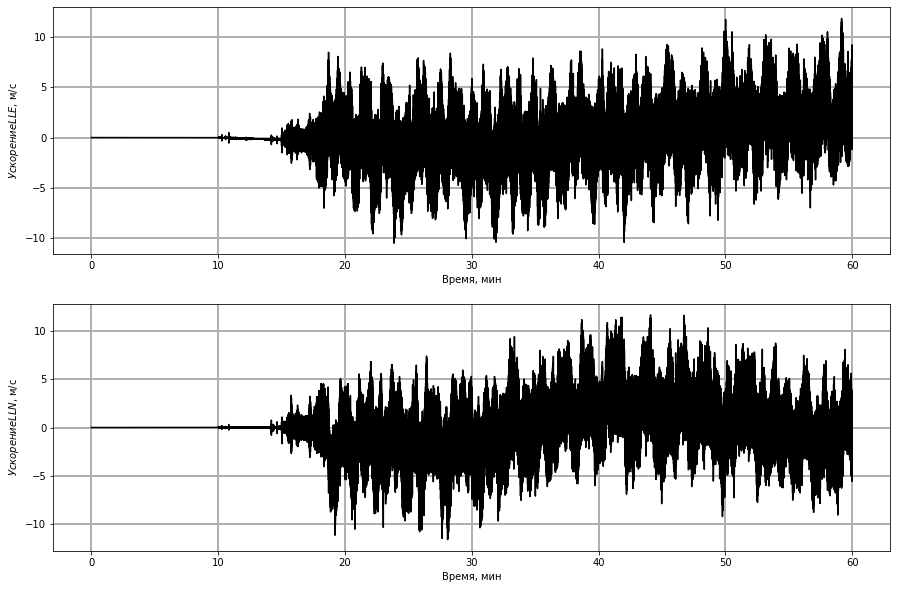

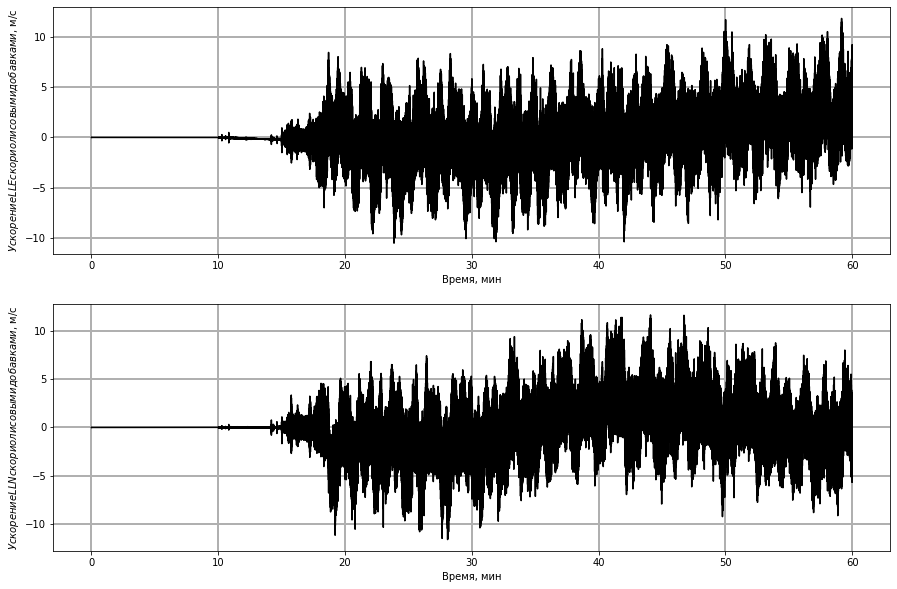

In [ ]:
# Графики
#time_GPS.append(time_GPS[i-1])
x_label = "Время, мин"

fig1, (fig1_ax1,fig1_ax2) = pyplot.subplots(nrows=2, ncols=1, figsize=(15, 10))
phi_arr.append(fi*rad2deg)
lmd_arr.append(lm*rad2deg)
# Широта
fig1_ax1.plot(time, phi_arr,color='k')
delta = 1 # Шаг для вывода графика по широте
fig1_ax1.set_ylabel("Широта, $\phi$ градус")
fig1_ax1.set_xlabel(x_label)
fig1_ax1.grid(which='major', linewidth=2)
fig1_ax1.grid(which='minor')
phi_GPS.append(phi_GPS[i])
fig1_ax1.plot(time, phi_GPS,color='b')
delta = 1 # Шаг для вывода графика по широте
fig1_ax1.set_ylabel("Широта, $\phi$ градус")
fig1_ax1.set_xlabel(x_label)
fig1_ax1.grid(which='major', linewidth=2)
fig1_ax1.grid(which='minor')

# Долгота
fig1_ax2.plot(time,lmd_arr, color='k')
fig1_ax2.set_ylabel("Долгота, $\lambda$ градус")
fig1_ax2.set_xlabel(x_label)
fig1_ax2.grid(which='major', linewidth=2)
fig1_ax2.grid(which='minor')
lmbda_GPS.append(lmbda_GPS[i])
fig1_ax2.plot(time,lmbda_GPS, color='b')
fig1_ax2.set_ylabel("Долгота, $\lambda$ градус")
fig1_ax2.set_xlabel(x_label)
fig1_ax2.grid(which='major', linewidth=2)
fig1_ax2.grid(which='minor')

x_label = "Долгота, $\lambda$ градус"
fig5, (fig5_ax1) = pyplot.subplots(nrows=1, ncols=1, figsize=(10, 10))
  
# Широта - долгота
fig5_ax1.plot(lmbda_GPS, phi_GPS,color='b')
delta = 1 # Шаг для вывода графика по широте
fig5_ax1.set_ylabel("Широта, $\phi$ градус")
fig5_ax1.set_xlabel(x_label)
fig5_ax1.grid(which='major', linewidth=2)
fig5_ax1.grid(which='minor')

# Широта - долгота
fig5_ax1.plot(lmd_arr, phi_arr,color='k')
delta = 1 # Шаг для вывода графика по широте
fig5_ax1.set_ylabel("Широта, $\phi$ градус")
fig5_ax1.set_xlabel(x_label)
fig5_ax1.grid(which='major', linewidth=2)
fig5_ax1.grid(which='minor')

x_label = "Долгота, $\lambda$ градус"
fig5, (fig51_ax1) = pyplot.subplots(nrows=1, ncols=1, figsize=(10, 10))
  
# Широта - долгота
fig51_ax1.plot(lmbda_GPS, phi_GPS,color='b')
delta = 1 # Шаг для вывода графика по широте
fig51_ax1.set_ylabel("Широта, $\phi$ градус")
fig51_ax1.set_xlabel(x_label)
fig51_ax1.grid(which='major', linewidth=2)
fig51_ax1.grid(which='minor')

x_label = "Время, мин"
fig2, (fig2_ax1,fig2_ax2) = pyplot.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Северная скорость
fig2_ax1.plot(time, Vn_arr, color = 'k')
fig2_ax1.set_ylabel("$V_n$, м/с")
fig2_ax1.set_xlabel(x_label)
fig2_ax1.grid(which='major', linewidth=2)
fig2_ax1.grid(which='minor')
#time_GPS.pop()
#Vn_GPS.append(Vn_GPS[i])
#fig2_ax1.plot(time, Vn_GPS, color = 'b')
#fig2_ax1.set_ylabel("$V_n$, м/с")
#fig2_ax1.set_xlabel(x_label)
#fig2_ax1.grid(which='major', linewidth=2)
#fig2_ax1.grid(which='minor')

# Восточная скорость
fig2_ax2.plot(time,Ve_arr,color = 'k')
fig2_ax2.set_ylabel("$V_e$, м/с")
fig2_ax2.set_xlabel(x_label)
fig2_ax2.grid(which='major', linewidth=2)
fig2_ax2.grid(which='minor')
#Ve_GPS.append(Ve_GPS[i])
#fig2_ax2.plot(time,Ve_GPS,color = 'b')
#fig2_ax2.set_ylabel("$V_e$, м/с")
#fig2_ax2.set_xlabel(x_label)
#fig2_ax2.grid(which='major', linewidth=2)
#fig2_ax2.grid(which='minor')

# Графики построения углов ориентации
fig3, (fig3_ax1,fig3_ax2, fig3_ax3) = pyplot.subplots(nrows=3, ncols=1, figsize=(15, 10)) # , fig4_ax4
    
# Курс
delta = 3
fig3_ax1.plot(time, H_arr,color = 'k')
fig3_ax1.set_ylabel("Курс $\H$, градус")
fig3_ax1.set_xlabel(x_label)
fig3_ax1.grid(which='major', linewidth=2)
fig3_ax1.grid(which='minor')
#fig3_ax1.plot(time_GPS, h_fromFile, color = 'b')
#fig3_ax1.set_ylabel("Курс $\H$, градус")
#fig3_ax1.set_xlabel(x_label)
#fig3_ax1.grid(which='major', linewidth=2)
#fig3_ax1.grid(which='minor')

# Крен
delta = 1
fig3_ax2.plot(time, gamma_arr, color = 'k')
fig3_ax2.set_ylabel("Крен $\gamma$, градус")
fig3_ax2.set_xlabel(x_label)
fig3_ax2.grid(which='major', linewidth=2)
fig3_ax2.grid(which='minor')
#fig3_ax2.plot(time_GPS, r_fromFile, color = 'b')
#fig3_ax2.set_ylabel("Крен $\gamma$, градус")
#fig3_ax2.set_xlabel(x_label)
#fig3_ax2.grid(which='major', linewidth=2)
#fig3_ax2.grid(which='minor')

# Тангаж
fig3_ax3.plot(time, theta_arr, color = 'k')
fig3_ax3.set_ylabel("Тангаж ($\Theta$), градус")
fig3_ax3.set_xlabel(x_label)
fig3_ax3.grid(which='major', linewidth=2)
fig3_ax3.grid(which='minor')
#p_fromFile.append( p_fromFile[i])
#fig3_ax3.plot(time, p_fromFile, color = 'b')
#fig3_ax3.set_ylabel("Тангаж ($\Theta$), градус")
#fig3_ax3.set_xlabel(x_label)
#fig3_ax3.grid(which='major', linewidth=2)
#fig3_ax3.grid(which='minor')

ombx_arr.append(0) 
omby_arr.append(0)
ombz_arr.append(0)

# Графики построения углов ориентации
fig11, (fig11_ax1,fig11_ax2, fig11_ax3) = pyplot.subplots(nrows=3, ncols=1, figsize=(15, 10)) # , fig4_ax4

delta = 3
fig11_ax1.plot(time, ombx_arr,color = 'k')
fig11_ax1.set_ylabel("Угловая скорость body x $\H$, градус/сек")
fig11_ax1.set_xlabel(x_label)
fig11_ax1.grid(which='major', linewidth=2)
fig11_ax1.grid(which='minor')

delta = 1
fig11_ax2.plot(time, omby_arr, color = 'k')
fig11_ax2.set_ylabel("Угловая скорость body y $\H$, градус/сек")
fig11_ax2.set_xlabel(x_label)
fig11_ax2.grid(which='major', linewidth=2)
fig11_ax2.grid(which='minor')

fig11_ax3.plot(time, ombz_arr, color = 'k')
fig11_ax3.set_ylabel("Уговая скорость body z $\H$, градус/сек")
fig11_ax3.set_xlabel(x_label)
fig11_ax3.grid(which='major', linewidth=2)
fig11_ax3.grid(which='minor')

acsbx_arr.append(a_1[i]) # acsbx_arr[i-1]
acsby_arr.append(a_2[i]) #acsby_arr[i-1]

x_label = "Время, мин"
fig12, (fig12_ax1,fig12_ax2) = pyplot.subplots(nrows=2, ncols=1, figsize=(15, 10))

fig12_ax1.plot(time, acsbx_arr, color = 'k')
fig12_ax1.set_ylabel("$Ускорение body x$, м/с")
fig12_ax1.set_xlabel(x_label)
fig12_ax1.grid(which='major', linewidth=2)
fig12_ax1.grid(which='minor')

fig12_ax2.plot(time, acsby_arr,color = 'k')
fig12_ax2.set_ylabel("$Ускорение body y$, м/с")
fig12_ax2.set_xlabel(x_label)
fig12_ax2.grid(which='major', linewidth=2)
fig12_ax2.grid(which='minor')

acsLx_arr.append(acs_LL[0]) #acsLx_arr[i-1]
acsLy_arr.append(acs_LL[1]) #acsLy_arr[i-1]

x_label = "Время, мин"
fig13, (fig13_ax1,fig13_ax2) = pyplot.subplots(nrows=2, ncols=1, figsize=(15, 10))

fig13_ax1.plot(time, acsLx_arr, color = 'k')
fig13_ax1.set_ylabel("$Ускорение LL E$, м/с")
fig13_ax1.set_xlabel(x_label)
fig13_ax1.grid(which='major', linewidth=2)
fig13_ax1.grid(which='minor')

fig13_ax2.plot(time, acsLy_arr,color = 'k')
fig13_ax2.set_ylabel("$Ускорение LL N$, м/с")
fig13_ax2.set_xlabel(x_label)
fig13_ax2.grid(which='major', linewidth=2)
fig13_ax2.grid(which='minor')

acsLkn_arr.append(an_k)
acsLke_arr.append(ae_k)

x_label = "Время, мин"
fig13, (fig13_ax1,fig13_ax2) = pyplot.subplots(nrows=2, ncols=1, figsize=(15, 10))

fig13_ax1.plot(time, acsLke_arr, color = 'k')
fig13_ax1.set_ylabel("$Ускорение LL E с кориолисовыми добавками$, м/с")
fig13_ax1.set_xlabel(x_label)
fig13_ax1.grid(which='major', linewidth=2)
fig13_ax1.grid(which='minor')

fig13_ax2.plot(time, acsLkn_arr,color = 'k')
fig13_ax2.set_ylabel("$Ускорение LL N с кориолисовыми добавками$, м/с")
fig13_ax2.set_xlabel(x_label)
fig13_ax2.grid(which='major', linewidth=2)
fig13_ax2.grid(which='minor')

pyplot.show()

In [ ]:
# Приращение углов
#  F_x = dus_1[i]*f
#  F_y = dus_2[i]*f
#  F_z = dus_3[i]*f

#  deltaF = np.sqrt(F_x**2+F_y**2+F_z**2)
#  if deltaF != 0:
#    deltalmd0=np.cos(deltaF/2)
#    deltalmd1=F_x/deltaF*np.sin(deltaF/2)
#    deltalmd2=F_y/deltaF*np.sin(deltaF/2)
#    deltalmd3=F_z/deltaF*np.sin(deltaF/2) 
#    A = np.array([[deltalmd0, -deltalmd1, -deltalmd2, -deltalmd3], [deltalmd1, deltalmd0, deltalmd3, -deltalmd2],
#                    [deltalmd2, -deltalmd3, deltalmd0, deltalmd1], [deltalmd3, deltalmd2, -deltalmd1, deltalmd0]])
#    Qpr = [Q2[0],Q2[1],Q2[2],Q2[3]] #) #np.array(
#    Q1 = np.dot(A, Qpr)
#  else:
#    Q1 = Q2
#  Q1 = normalization(Q1)
#  omegaxnSS = -Vn/(Rphi) #-k3*(fi - fi0);
#  omegaynSS = Ve/(Rl)+U*np.cos(fi) #+k3*(lm-lm)*np.cos(fi);
#  omegaznSS = Ve/(Rl)*np.tan(fi)+U*np.sin(fi);
#  omegaxn = omegaxnSS
#  omegayn = omegaynSS
#  omegazn = omegaznSS 
#  omegan = np.sqrt(omegaxn**2+omegayn**2+omegazn**2)        

#  if omegan !=0:
#    deltam0 = np.cos((omegan)*f/2);
#    deltam1 = -(omegaxn)/(omegan)*np.sin((omegan)*f/2)
#    deltam2 = -(omegayn)/(omegan)*np.sin((omegan)*f/2)
#    deltam3 = -(omegazn)/(omegan)*np.sin((omegan)*f/2)   
#    q0 = Q1[0]
#    q1 = Q1[1]
#    q2 = Q1[2]
#    q3 = Q1[3]
#    D = np.array(np.zeros((4, 4)))
#    D = np.array([[q0, -q1, -q2, -q3], [q1, q0, q3, -q2], [q2, -q3, q0, q1], [q3, q2, -q1, q0]])
#    Q2m = np.dot(D,[deltam0, deltam1, deltam2, deltam3]) #)  np.array(
#    Q2 = np.array([Q2m[0], Q2m[1], Q2m[2], Q2m[3]])
#  else:
#    Q2 = Q1
#    Q2 = normalization(Q2)
#  Q2 = Q1




      # Расчет МНК через кватернион
    #q0, qvec = angle2quat(h_fromFile[i], r_fromFile[i], p_fromFile[i])
    #Q2 = [q0, qvec[0], qvec[1], qvec[2]]
    #Q2 = quat(h_fromFile[i], r_fromFile[i], p_fromFile[i])
    #H_arr.append(rad2deg*(np.arctan(2*(Q2[0]*Q2[2]-Q2[1]*Q2[3])/(Q2[0]**2+Q2[1]**2-0.5)))) # Курс
    #theta_arr.append(rad2deg*(np.arcsin(2*Q2[1]*Q2[2]+2*Q2[0]*Q2[3]))) # Тангаж
    #gamma_arr.append(rad2deg*(2*np.arctan((Q2[0]*Q2[1]-Q2[2]*Q2[3])/(Q2[0]**2+Q2[2]**2-0.5)))) # Крен